In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import tensorflow_datasets as tfds

In [ ]:
!unzip archive\ \(3\).zip    #dataset link https://www.kaggle.com/datasets/andrewmvd/animal-faces

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: archive (2)/afhq/train/pixabay_cat_004640.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004641.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004642.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004643.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004644.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004645.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004646.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004647.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004648.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004649.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004650.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004651.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004653.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004654.jpg  
  inflating: archive (2)/afhq/train/pixabay_cat_004656.jpg  
  inflating: archive (2)/afhq/train/pi

In [ ]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filenames=os.listdir("/content/archive (2)/afhq/train")
categories=[]
for f_name in filenames:
    category=f_name.split('_')[1]
    if category=='cat':
        categories.append(0)
    if category=='dog':
        categories.append(1)
    if category=='wild':
        categories.append(2)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
df.head(10)

,filename,category
0,pixabay_dog_000191.jpg,1
1,pixabay_cat_002994.jpg,0
2,pixabay_cat_003139.jpg,0
3,pixabay_cat_004004.jpg,0
4,flickr_dog_000227.jpg,1
5,pixabay_dog_002314.jpg,1
6,pixabay_dog_002457.jpg,1
7,pixabay_cat_001606.jpg,0
8,pixabay_dog_001598.jpg,1
9,pixabay_cat_004368.jpg,0


In [ ]:
import seaborn as sns
sns.countplot(df['category'])

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [ ]:
df["category"] = df["category"].replace({0:'cat',1:'dog',2:'wild'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "/content/archive (2)/afhq/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/archive (2)/afhq/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)
test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)




Found 11704 validated image filenames belonging to 3 classes.
Found 2926 validated image filenames belonging to 3 classes.


In [ ]:
epochs=40
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
   
)

Epoch 1/40
781/781 [==============================] - 103s 132ms/step - loss: 0.2015 - accuracy: 0.9347 - val_loss: 0.1018 - val_accuracy: 0.9651
Epoch 2/40
781/781 [==============================] - 104s 133ms/step - loss: 0.1922 - accuracy: 0.9387 - val_loss: 0.1220 - val_accuracy: 0.9535
Epoch 3/40
781/781 [==============================] - 102s 131ms/step - loss: 0.1875 - accuracy: 0.9371 - val_loss: 0.1012 - val_accuracy: 0.9631
Epoch 4/40
781/781 [==============================] - 103s 131ms/step - loss: 0.1860 - accuracy: 0.9400 - val_loss: 0.5543 - val_accuracy: 0.8691
Epoch 5/40
781/781 [==============================] - 104s 133ms/step - loss: 0.1752 - accuracy: 0.9425 - val_loss: 0.0884 - val_accuracy: 0.9733
Epoch 6/40
781/781 [==============================] - 102s 131ms/step - loss: 0.1714 - accuracy: 0.9434 - val_loss: 0.0845 - val_accuracy: 0.9710
Epoch 7/40
781/781 [==============================] - 102s 131ms/step - loss: 0.1530 - accuracy: 0.9493 - val_loss: 0.1043 -

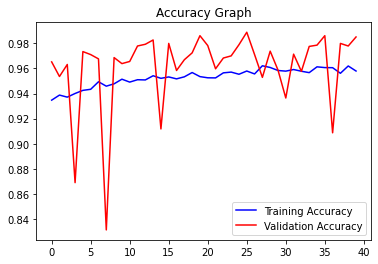

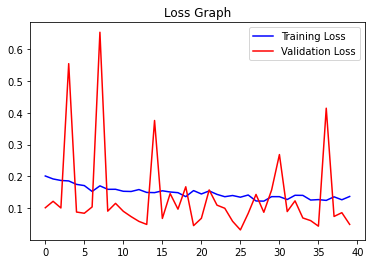

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
model.save("model1_catsVSdogs_10epoch.h5")

In [ ]:
test_filenames = os.listdir("/content/archive (2)/afhq/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_generator = train_datagen.flow_from_dataframe(test_df,
                                                 "/content/archive (2)/afhq/test/",x_col='filename',y_col=None,
                                                 target_size=Image_Size,
                                                 class_mode=None,
                                                 batch_size=batch_size)



Found 1500 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dogs': 1, 'cats': 2 ,'panda':0})

In [ ]:
sns.countplot(test_df['category'])

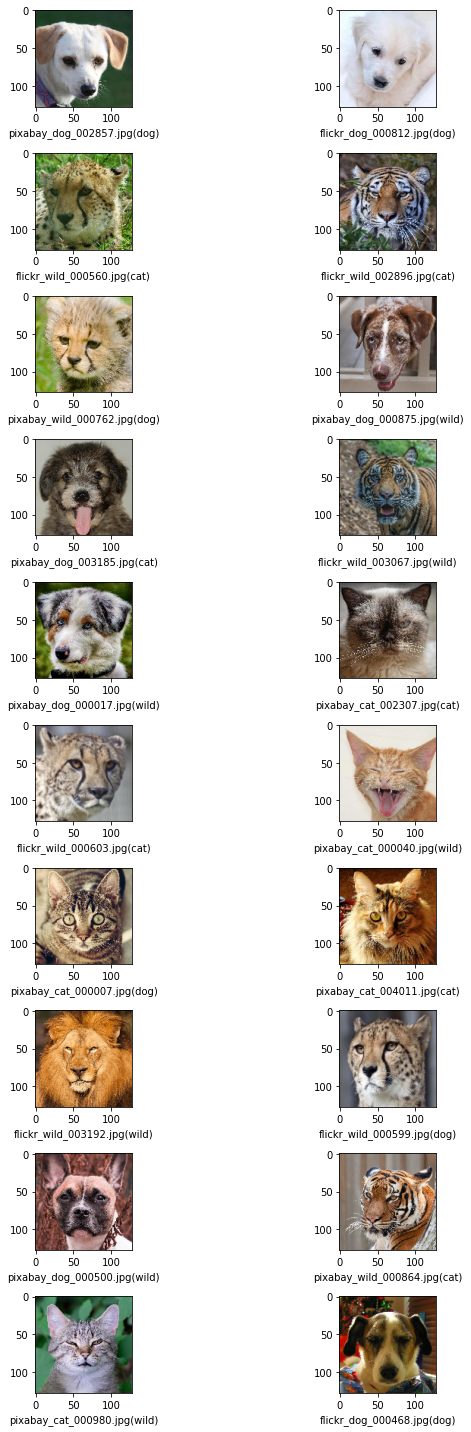

In [ ]:
sample_test = test_df.head(20)
sample_test.head()
plt.figure(figsize=(10, 20))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/archive (2)/afhq/test/"+filename, target_size=Image_Size)
    plt.subplot(10, 2, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()